In [1]:
import requests
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
from polygon import RESTClient


In [2]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['font.family'] = 'serif'

In [3]:
def get_data_by_hour(symbol):
    key = 'YZj_Ugd4fkCRX57STH5MeItRlAz31DRN'
    client = RESTClient(key)
    query = True
    from_date = "2012-01-01"
    to_date = datetime.today().date().strftime("%Y-%m-%d")
    data_for_df = []
    while query:
        resp = client.stocks_equities_aggregates(symbol, 1, "hour", from_date, to_date, unadjusted=True, limit=50000)
        if 'results' in dir(resp):
            results = resp.results
            data_for_df = data_for_df + results[:-1]
            date = datetime.fromtimestamp((resp.results[-1]['t'])/1000.0)
            from_date = date.date().strftime("%Y-%m-%d")
            if from_date == to_date:
                query = False 
        else:
            query = False 

    
    handledData = pd.DataFrame(data=data_for_df)
    handledData.columns = ['volume', 'vw', 'open', 'close', 'high', 'low', 'time', 'number']
    handledData.drop_duplicates(subset=['time'], inplace=True)
    handledData.index = pd.to_datetime(handledData['time'].values, unit='ms').to_pydatetime()
    handledData.drop('time', axis=1, inplace=True)
    handledData.dropna(inplace=True)

    plt.figure(figsize=(15, 5))
    plt.plot(handledData.index, handledData['close'])
    plt.grid(True)
    return handledData

,volume,vw,open,close,high,low,number
2012-01-03 12:00:00,1100.0,5.5000,5.50,5.50,5.500,5.50,6
2012-01-03 13:00:00,24951.0,5.5243,5.48,5.54,5.540,5.48,29
2012-01-03 14:00:00,1359139.0,5.5509,5.40,5.55,5.590,5.40,3115
2012-01-03 15:00:00,2822896.0,5.5226,5.55,5.52,5.580,5.45,5652
2012-01-03 16:00:00,1179854.0,5.4913,5.52,5.49,5.525,5.47,2604
...,...,...,...,...,...,...,...
2021-05-18 20:00:00,357285.0,74.4412,74.44,74.35,74.620,74.35,882
2021-05-18 21:00:00,15594.0,74.3818,74.35,74.40,74.440,74.34,233
2021-05-18 22:00:00,11342.0,74.3936,74.40,74.38,74.440,74.31,115
2021-05-18 23:00:00,41856.0,74.3526,74.36,74.10,74.500,74.10,335


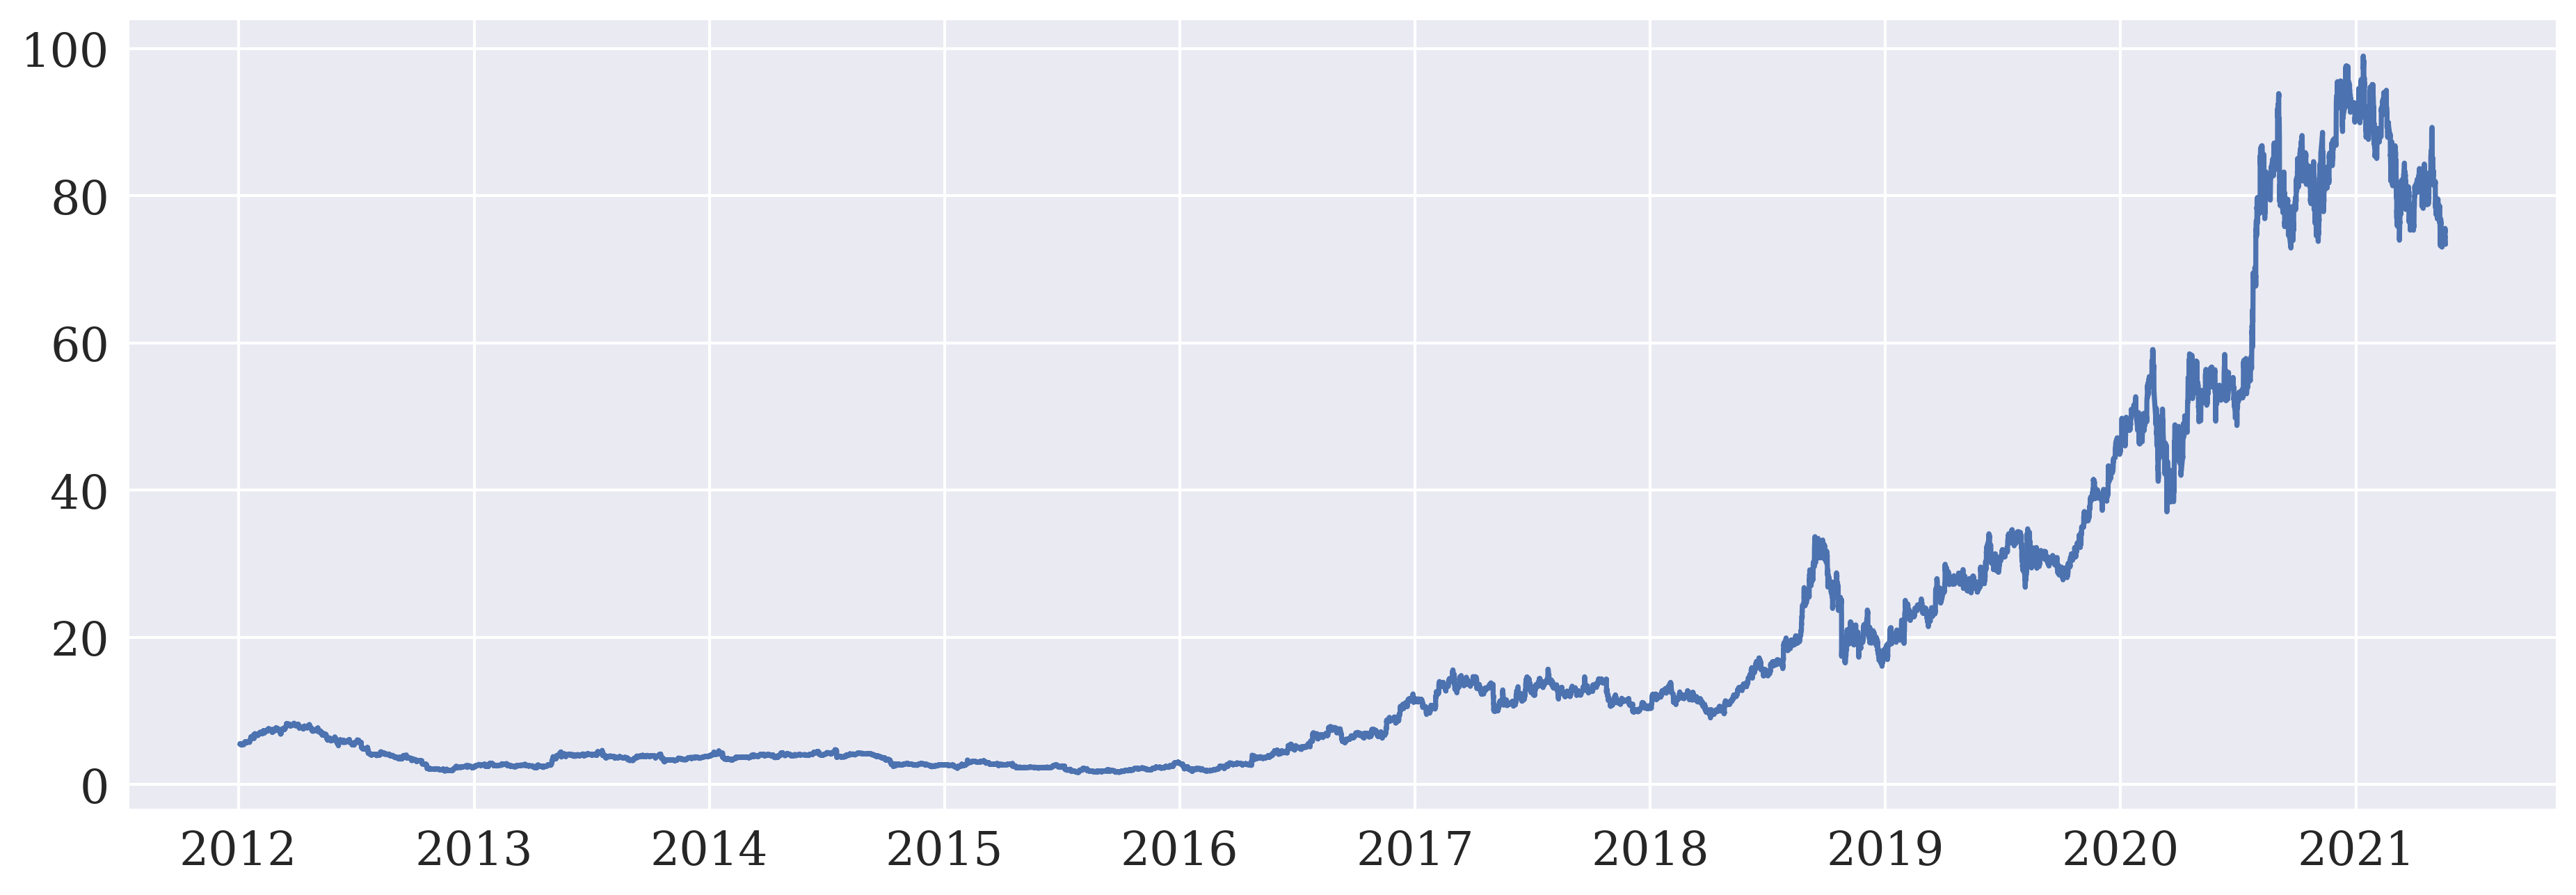

In [4]:
data_stock = get_data_by_hour("AMD")
data_stock

In [5]:
data_stock.loc['2012-06-21 10:00:00']

volume    100.00
vw          6.12
open        6.12
close       6.12
high        6.12
low         6.12
number      1.00
Name: 2012-06-21 10:00:00, dtype: float64

In [6]:
price = data_stock['close']


def get_Daily_Volatility(close,span0=24):
    # simple percentage returns
    df0=close.pct_change()
    # 20 days, a month EWM's std as boundary
    df0=df0.ewm(span=span0).std()
    df0.dropna(inplace=True)
    return df0
df0 = get_Daily_Volatility(price)

#set the boundary of barriers, based on 20 days EWM
daily_volatility = get_Daily_Volatility(price)
# how many days we hold the stock which set the vertical barrier
t_final = 10 
#the up and low boundary multipliers
upper_lower_multipliers = [3, 2]
#allign the index
prices = price[daily_volatility.index]

def get_3_barriers():
    #create a container
    barriers = pd.DataFrame(columns=['days_passed', 'price', 'vert_barrier', 'top_barrier', 'bottom_barrier'], index = daily_volatility.index)
    for day, vol in daily_volatility.iteritems():
        days_passed = len(daily_volatility.loc[daily_volatility.index[0] : day])
        #set the vertical barrier 
        if (days_passed + t_final < len(daily_volatility.index) \
            and t_final != 0):
            vert_barrier = daily_volatility.index[
                                days_passed + t_final]
        else:
            vert_barrier = np.nan
        #set the top barrier
        if upper_lower_multipliers[0] > 0:
            top_barrier = prices.loc[day] + prices.loc[day] * \
                          upper_lower_multipliers[0] * vol
        else:
            #set it to NaNs
            top_barrier = pd.Series(index=prices.index)
        #set the bottom barrier
        if upper_lower_multipliers[1] > 0:
            bottom_barrier = prices.loc[day] - prices.loc[day] * \
                          upper_lower_multipliers[1] * vol
        else: 
            #set it to NaNs
            bottom_barrier = pd.Series(index=prices.index)
        barriers.loc[day, ['days_passed', 'price', \
        'vert_barrier','top_barrier', 'bottom_barrier']] = \
         days_passed, prices.loc[day], vert_barrier, \
         top_barrier, bottom_barrier
    barriers['out'] = None
    return barriers


barriers = get_3_barriers()

def get_labels():
    for i in range(len(barriers.index)):
        start = barriers.index[i]
        end = barriers.vert_barrier[i]
        if pd.notna(end):
                # assign the initial and final price
                price_initial = barriers.price[start]
                price_final = barriers.price[end]
    # assign the top and bottom barriers
                top_barrier = barriers.top_barrier[i]
                bottom_barrier = barriers.bottom_barrier[i]
    #set the profit taking and stop loss conditons
                condition_pt = (barriers.price[start: end] >= \
                 top_barrier).any()
                condition_sl = (barriers.price[start: end] <= \
                 bottom_barrier).any()
    #assign the labels
                if condition_pt: 
                    barriers['out'][i] = 1
                elif condition_sl: 
                    barriers['out'][i] = -1    
                else: 
                    barriers['out'][i] = 0
    return

get_labels()

In [7]:
barriers.out.value_counts()

 0    13484
-1    11267
 1     8295
Name: out, dtype: int64

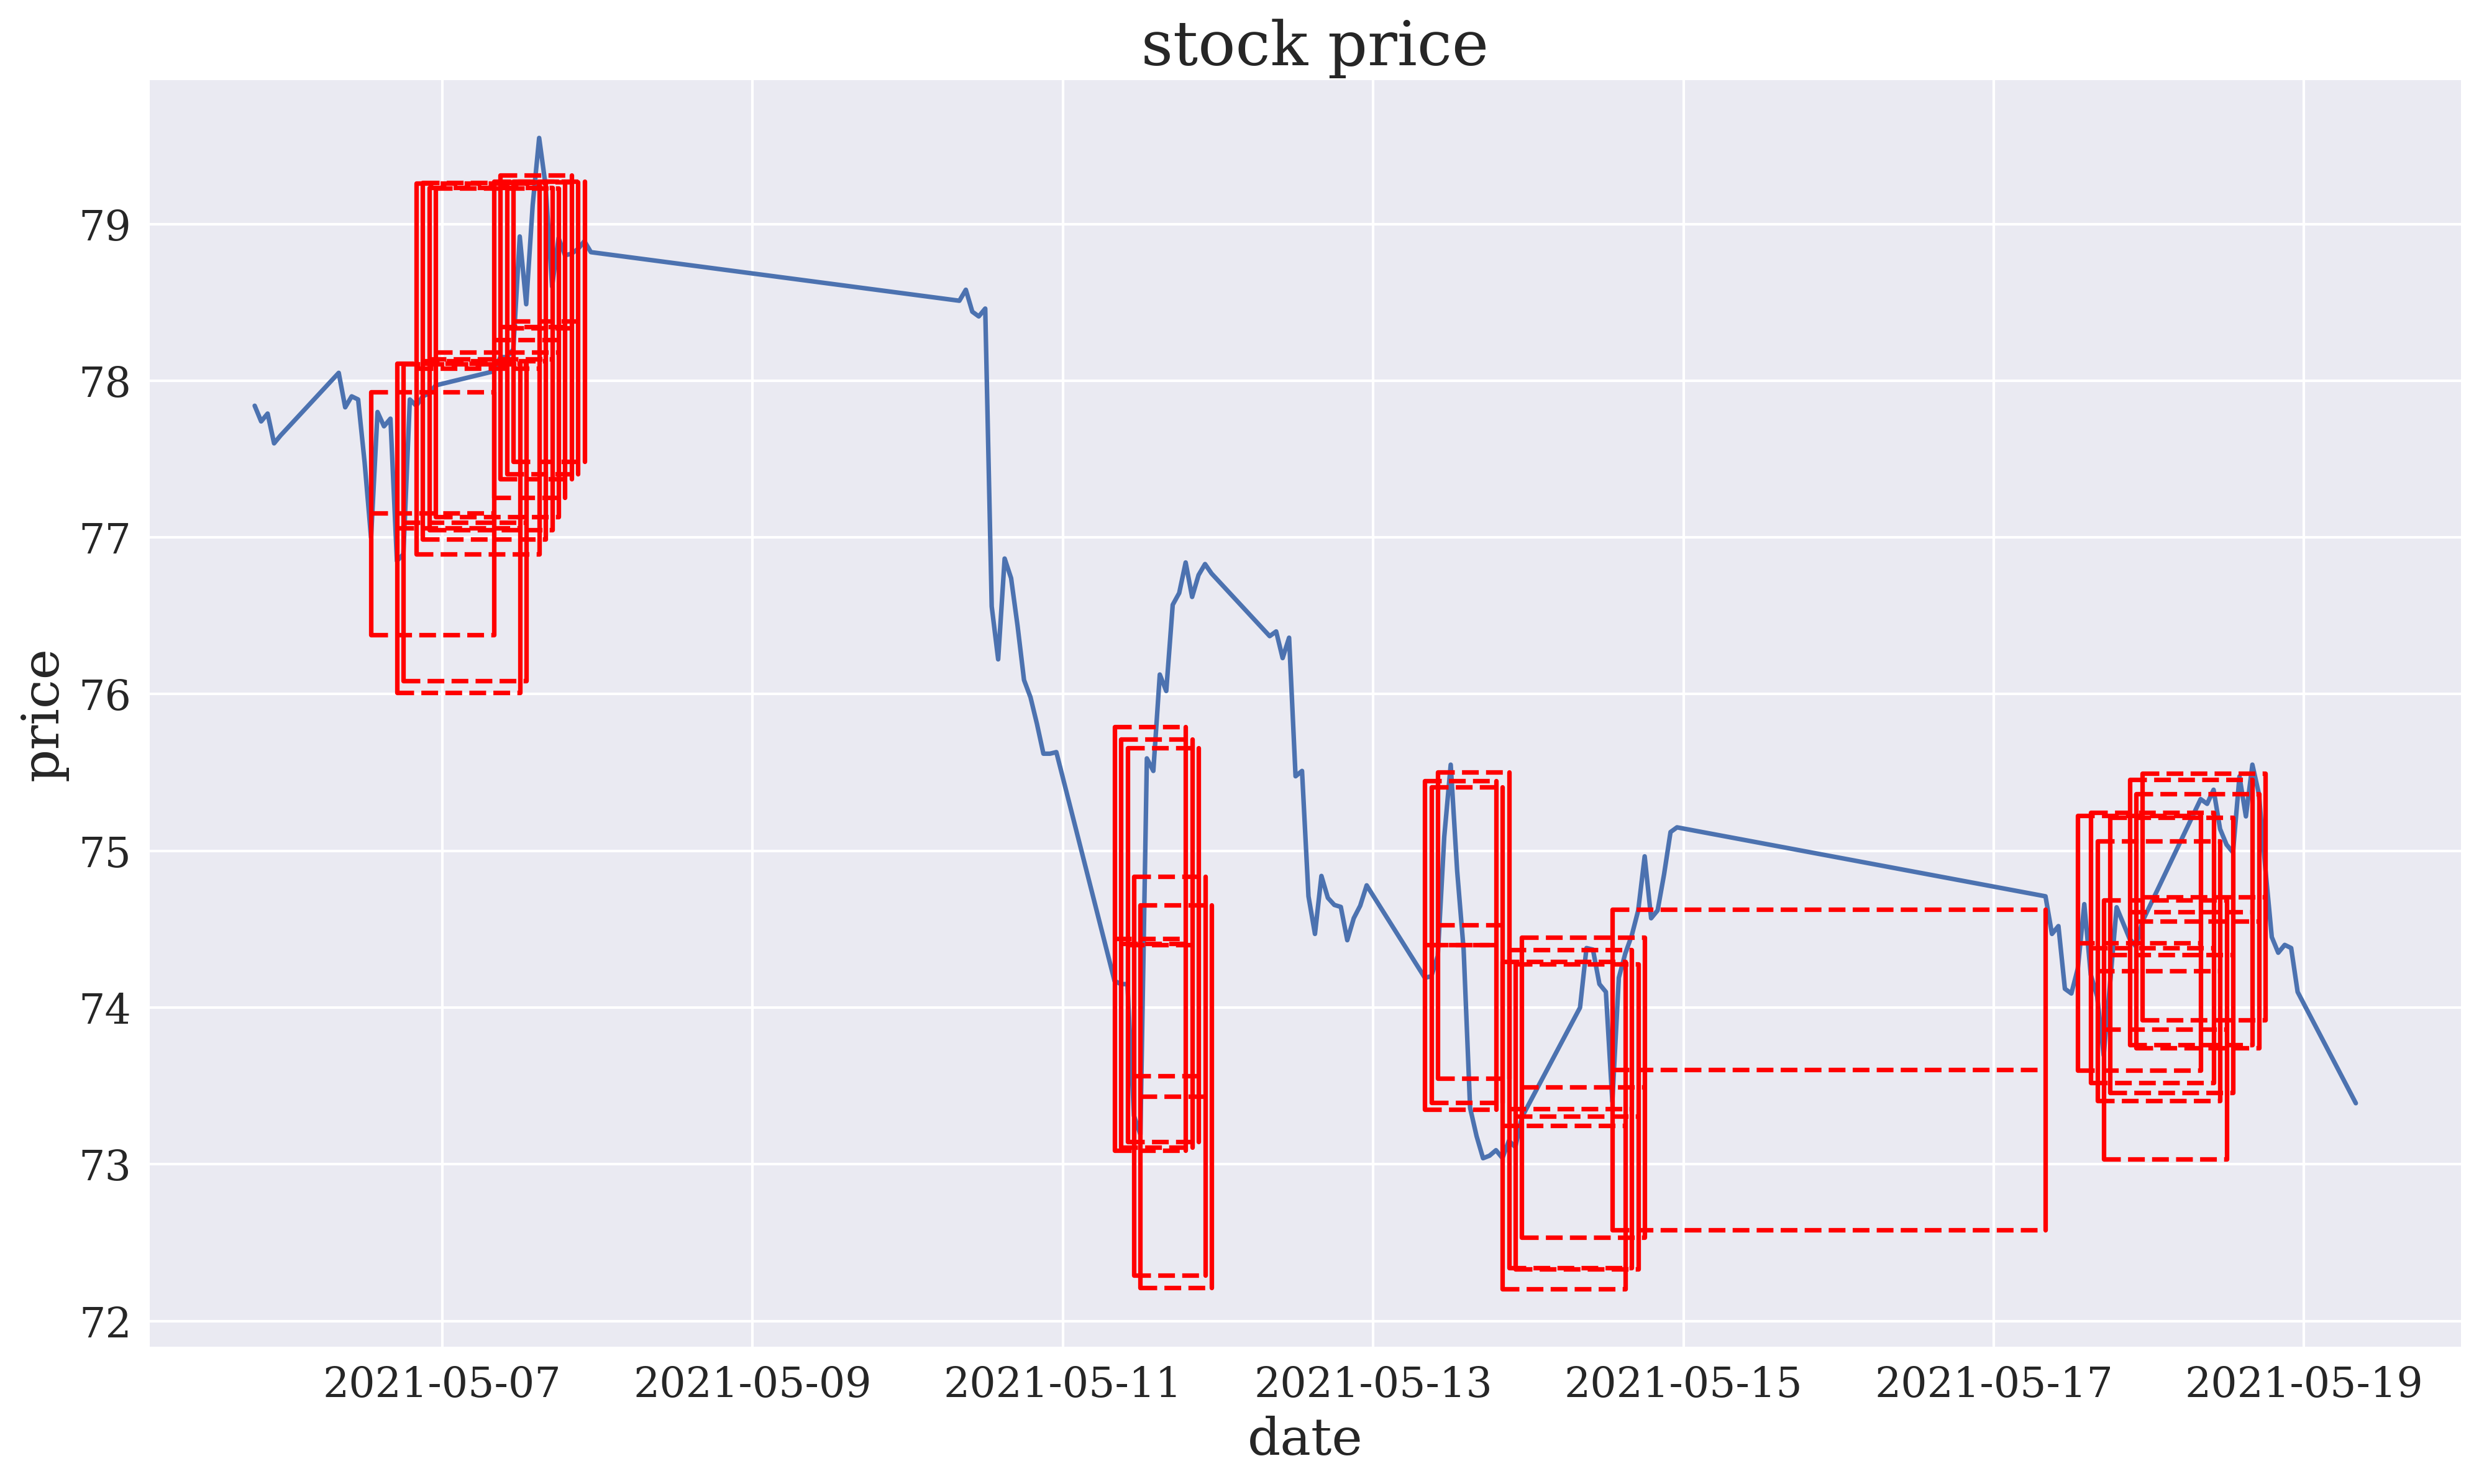

In [8]:
fig,ax = plt.subplots()
ax.set(title=' stock price', xlabel='date', ylabel='price')
ax.plot(barriers.price[-150:])
for i in barriers.index[-155:]:
    barrier = barriers.loc[i]
    start = i
    end = barrier.vert_barrier
    if not pd.isnull(end) and barrier.out == 1:
        upper_barrier = barrier.top_barrier
        lower_barrier = barrier.bottom_barrier
        ax.plot([start, end], [upper_barrier, upper_barrier], 'r--');
        ax.plot([start, end], [lower_barrier, lower_barrier], 'r--');
        ax.plot([start, end], [(lower_barrier + upper_barrier)*0.5, (lower_barrier + upper_barrier)*0.5], 'r--');
        ax.plot([start, start], [lower_barrier, upper_barrier], 'r-');
        ax.plot([end, end], [lower_barrier, upper_barrier], 'r-');

In [9]:
def create_HLCV(i): 
    df = pd.DataFrame(index=data_stock.index)
    df[f'high_{i}'] = data_stock.high.rolling(i).max()
    df[f'low_{i}'] = data_stock.low.rolling(i).min()
    df[f'close_{i}'] = data_stock.close.rolling(i).\
                        apply(lambda x:x[-1]) 
    df[f'volume_{i}'] = data_stock.volume.rolling(i).sum()
    
    return df

In [10]:
def create_features(i):
    df = create_HLCV(i)
    high = df[f'high_{i}']
    low = df[f'low_{i}']
    close = df[f'close_{i}']
    volume = df[f'volume_{i}']
    features = pd.DataFrame(index=data_stock.index)
    features[f'volume_{i}'] = volume
    features[f'price_spread_{i}'] = high - low
    features[f'close_loc_{i}'] = (high - close) / (high - low)
    features[f'close_change_{i}'] = close.diff()
    
    return features

In [ ]:
def create_bunch_of_features():
    days = [1,2,3,5,6,7,8,9,10,20,40,60]
    bunch_of_features = pd.DataFrame(index=data_stock.index)
    for day in days:
        f = create_features(day)
        bunch_of_features = bunch_of_features.join(f)
    
    return bunch_of_features

bunch_of_features = create_bunch_of_features()
bunch_of_features.info()

In [ ]:
dropna_barriers = barriers.dropna()
data = bunch_of_features[60:-13].assign(out=dropna_barriers[58:-2].out)
data.dropna(inplace=True)
out = data.out
out=out.astype('int')
data.drop('out', axis=1, inplace=True)
data

In [ ]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=20)

model.fit(data, out)

In [ ]:
predictions = model.predict(bunch_of_features[-30:])

In [ ]:
predictions

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=1000, class_weight='balanced_subsample', criterion="entropy")
clf.fit(data, out)

In [ ]:
predictions2 = clf.predict(bunch_of_features.iloc[-30:])

In [ ]:
predictions2

In [ ]:
barriers[-30:]

In [ ]:
fig,ax = plt.subplots()
ax.set(title=' stock price', xlabel='date', ylabel='price')
ax.plot(barriers.price[-50:])
for i in barriers.index[-10:]:
    barrier = barriers.loc[i]
    start = i
    end = (datetime.strptime(i.strftime("%Y-%m-%d %H:%M:%S"), '%Y-%m-%d %H:%M:%S') + timedelta(hours = 10))
    upper_barrier = barrier.top_barrier
    lower_barrier = barrier.bottom_barrier
    ax.plot([start, end], [upper_barrier, upper_barrier], 'r--');
    ax.plot([start, end], [lower_barrier, lower_barrier], 'r--');
    ax.plot([start, end], [(lower_barrier + upper_barrier)*0.5, (lower_barrier + upper_barrier)*0.5], 'r--');
    ax.plot([start, start], [lower_barrier, upper_barrier], 'r-');
    ax.plot([end, end], [lower_barrier, upper_barrier], 'r-');